In [2]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [3]:
#change the tickers here according to what's in the portfolio
tickers = ["^FVX"]

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [4]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^FVX    1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


## Function that saves dataframe to CSV

In [10]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [6]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [11]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [12]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [13]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [14]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [15]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [16]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [17]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [18]:
#change to the list of stocks we using
port_list = ["^FVX"]

#add in the weightage of stocks
port_shares = [1.0]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,^FVX,Total,daily_return
Date,,,
2017-01-03,1.944,1.944,NaN
2017-01-04,1.947,1.947,0.001543
2017-01-05,1.863,1.863,-0.043143
2017-01-06,1.922,1.922,0.031669
2017-01-09,1.881,1.881,-0.021332
...,...,...,...
2020-12-24,0.364,0.364,-0.034483
2020-12-28,0.364,0.364,0.000000
2020-12-29,0.378,0.378,0.038462


## Get old data for portfolio

In [19]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,^FVX,Total,daily_return
Date,,,
2017-01-03,1.944,1.944,NaN
2017-01-04,1.947,1.947,0.001543
2017-01-05,1.863,1.863,-0.043143
2017-01-06,1.922,1.922,0.031669
2017-01-09,1.881,1.881,-0.021332
...,...,...,...
2020-12-24,0.364,0.364,-0.034483
2020-12-28,0.364,0.364,0.000000
2020-12-29,0.378,0.378,0.038462


## Forecasting

In [20]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [21]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [22]:
tot_port_df

,^FVX,Total,daily_return
Date,,,
2017-01-03,1.944,1.944,NaN
2017-01-04,1.947,1.947,0.001543
2017-01-05,1.863,1.863,-0.043143
2017-01-06,1.922,1.922,0.031669
2017-01-07,1.922,1.922,0.031669
...,...,...,...
2020-12-27,0.364,0.364,-0.034483
2020-12-28,0.364,0.364,0.000000
2020-12-29,0.378,0.378,0.038462


In [23]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["^FVX", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [24]:
tot_port_df

,Total
Date,
2017-01-03,1.944
2017-01-04,1.947
2017-01-05,1.863
2017-01-06,1.922
2017-01-07,1.922
...,...
2020-12-27,0.364
2020-12-28,0.364
2020-12-29,0.378


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1459


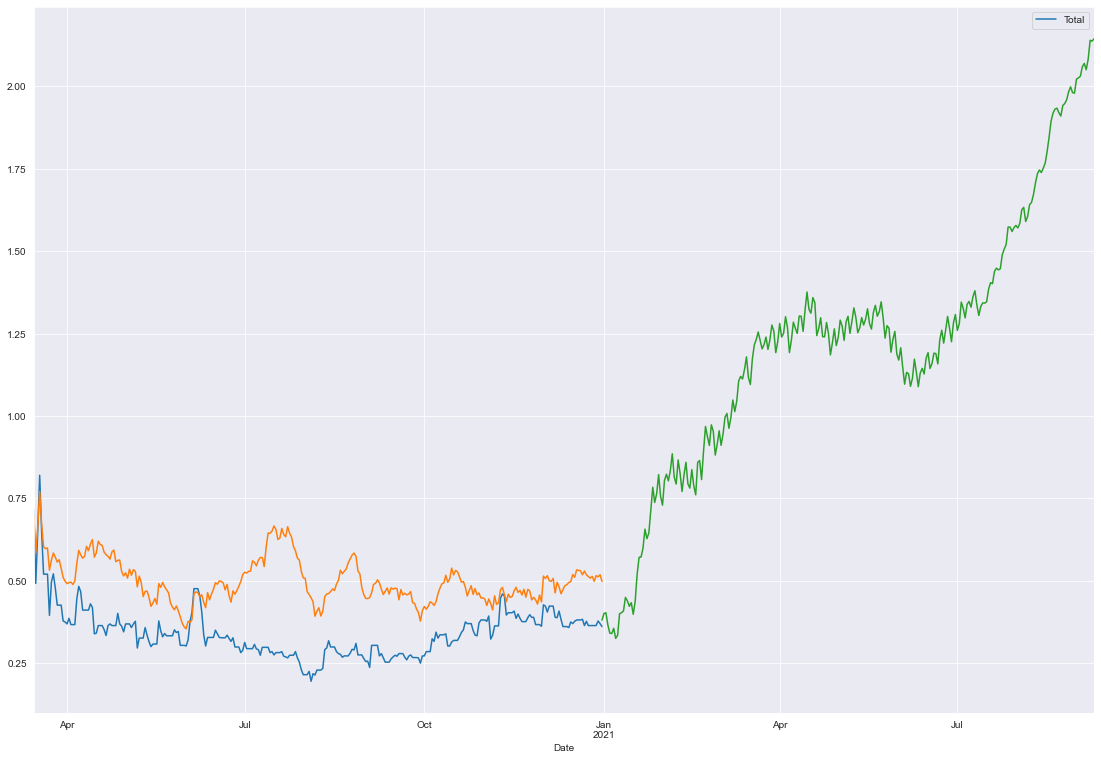

In [25]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [26]:
forecast

2020-12-31    0.380494
2021-01-01    0.400758
2021-01-02    0.402755
2021-01-03    0.366055
2021-01-04    0.341083
                ...   
2021-09-05    2.050504
2021-09-06    2.082330
2021-09-07    2.139680
2021-09-08    2.137404
2021-09-09    2.144260
Freq: D, Length: 253, dtype: float64

In [27]:
forecast_df = pd.DataFrame(forecast)

In [28]:
forecast_df

,0
2020-12-31,0.380494
2021-01-01,0.400758
2021-01-02,0.402755
2021-01-03,0.366055
2021-01-04,0.341083
...,...
2021-09-05,2.050504
2021-09-06,2.082330
2021-09-07,2.139680
2021-09-08,2.137404


In [29]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [30]:
return_series

,0
2020-12-31,NaN
2021-01-01,0.053257
2021-01-02,0.058507
2021-01-03,-0.037948
2021-01-04,-0.103579
...,...
2021-09-05,4.389061
2021-09-06,4.472704
2021-09-07,4.623430
2021-09-08,4.617448


In [31]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                     0
2021-09-09  463.546558


## Backtesting

In [32]:
tickers2 = ["^FVX"]

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [33]:
panel_data2 = panel_data2['Adj Close']

In [34]:
panel_data2

Symbols,^FVX
Date,
2020-12-30,0.370
2020-12-31,0.361
2021-01-04,0.354
2021-01-05,0.377
2021-01-06,0.432
...,...
2021-12-23,1.243
2021-12-27,1.252
2021-12-28,1.245


## Portfolio Analysis

In [35]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,^FVX
Date,
2020-12-31,-0.024324
2021-01-04,-0.019391
2021-01-05,0.064972
2021-01-06,0.145889
2021-01-07,0.050926


In [36]:
portfolio_weights = [1.0]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,^FVX
Date,
2020-12-31,-0.024324
2021-01-04,-0.019391
2021-01-05,0.064972
2021-01-06,0.145889
2021-01-07,0.050926


In [37]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31   -0.024324
2021-01-04   -0.019391
2021-01-05    0.064972
2021-01-06    0.145889
2021-01-07    0.050926
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,244.3%
Cumulative returns,244.3%
Annual volatility,74.4%
Sharpe ratio,2.02
Calmar ratio,7.93
Stability,0.68
Max drawdown,-30.8%


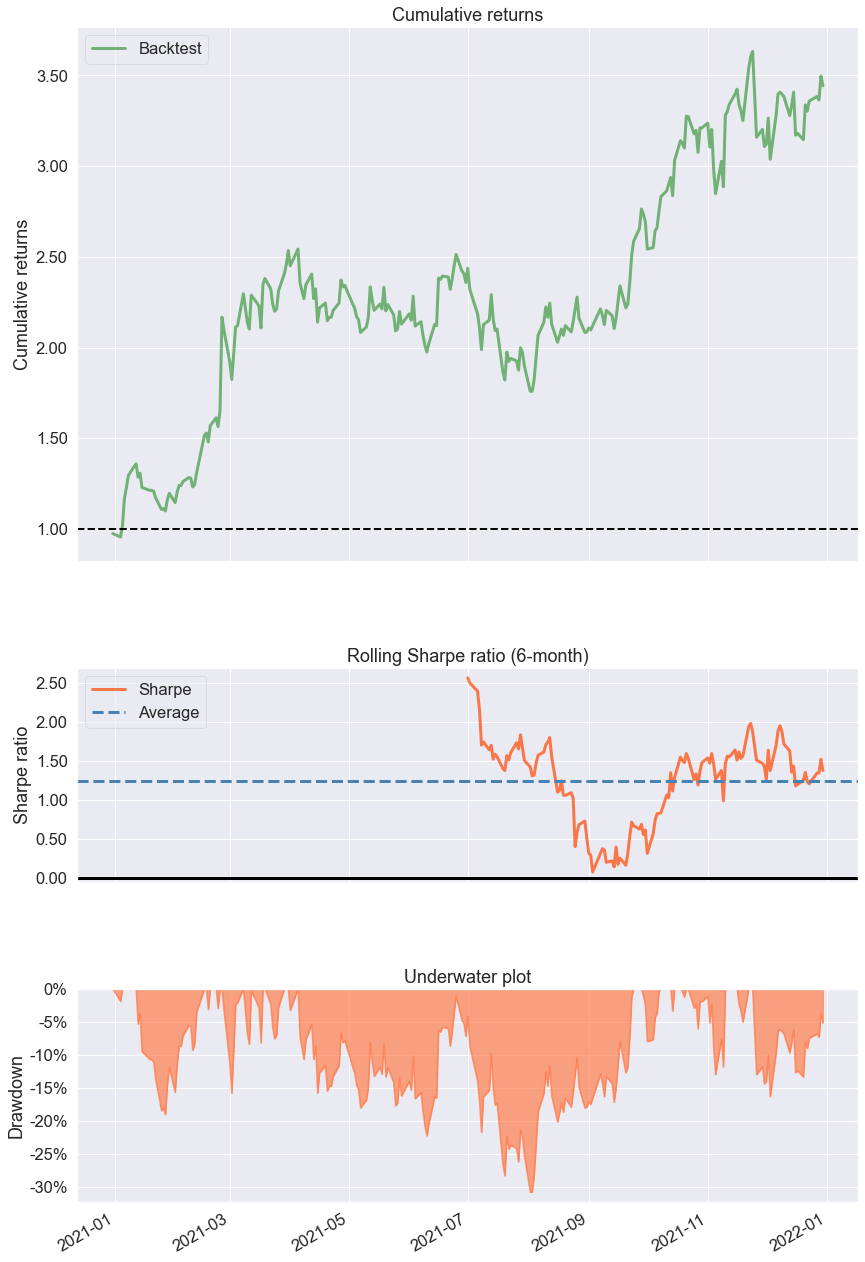

In [38]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [39]:
import itertools

In [40]:
weights = [1.0]

In [41]:
panel_data2 = panel_data2 * weights

In [42]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [43]:
#forecasted portfolio value
panel_data2

Symbols,^FVX,Total
Date,,
2020-12-30,0.370,0.370
2020-12-31,0.361,0.361
2021-01-04,0.354,0.354
2021-01-05,0.377,0.377
2021-01-06,0.432,0.432
...,...,...
2021-12-23,1.243,1.243
2021-12-27,1.252,1.252
2021-12-28,1.245,1.245


In [44]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [45]:
actual_portfolio_value

[0.3700000047683716,
 0.3610000014305115,
 0.3540000021457672,
 0.37700000405311584,
 0.4320000112056732,
 0.45399999618530273,
 0.4790000021457672,
 0.49799999594688416,
 0.503000020980835,
 0.47600001096725464,
 0.48399999737739563,
 0.45500001311302185,
 0.4490000009536743,
 0.4490000009536743,
 0.44699999690055847,
 0.4339999854564667,
 0.4099999964237213,
 0.41200000047683716,
 0.40700000524520874,
 0.4300000071525574,
 0.4429999887943268,
 0.42399999499320984,
 0.4449999928474426,
 0.45899999141693115,
 0.45899999141693115,
 0.46700000762939453,
 0.4749999940395355,
 0.4740000069141388,
 0.4560000002384186,
 0.460999995470047,
 0.48500001430511475,
 0.5609999895095825,
 0.5659999847412109,
 0.5479999780654907,
 0.5809999704360962,
 0.597000002861023,
 0.5789999961853027,
 0.6119999885559082,
 0.8019999861717224,
 0.7760000228881836,
 0.7110000252723694,
 0.675000011920929,
 0.7269999980926514,
 0.7820000052452087,
 0.7850000262260437,
 0.8500000238418579,
 0.8209999799728394,
 0.

In [46]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [47]:
forecasted_portfolio_value

[0.3804938062901322,
 0.40075783987829705,
 0.40275547035043546,
 0.3660550143687466,
 0.3410825768497009,
 0.3400125553647507,
 0.35561876496906,
 0.32523279323365606,
 0.33465194850460533,
 0.4000236050959367,
 0.40304202292715446,
 0.4084260968963354,
 0.44958907997798814,
 0.4389490514331008,
 0.4225254268415911,
 0.43333853578734144,
 0.3983334942352815,
 0.43801895390439094,
 0.5202016274704038,
 0.5711637232807403,
 0.5719330554375901,
 0.5987088225106927,
 0.6566450956490886,
 0.627713157221548,
 0.6450976237784563,
 0.714210838295962,
 0.7836915427624822,
 0.7375630686737054,
 0.7642665832626329,
 0.8220844371725108,
 0.7559769728184378,
 0.729486907099314,
 0.8043037304640612,
 0.8232811308260303,
 0.8031520742875681,
 0.8343878626945336,
 0.8854238207315895,
 0.8143462774244631,
 0.7935351116217938,
 0.8665481173022701,
 0.8255123104171123,
 0.7708214815272723,
 0.821172790508456,
 0.8592930167127026,
 0.7939690576180821,
 0.7809158343766716,
 0.8371618131444799,
 0.78816915

## Calculate MAPE of forecasted period

In [48]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.43
MAPE % : 42.59 %



## Mean Squared Error

In [49]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value))

0.1795186433045453


## Forecast for future

In [50]:
#change to the list of stocks we using
port_list = ["^FVX"]

#add in the weightage of stocks
port_shares = [1.0]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,^FVX,Total,daily_return
Date,,,
2017-01-03,1.944,1.944,NaN
2017-01-04,1.947,1.947,0.001543
2017-01-05,1.863,1.863,-0.043143
2017-01-06,1.922,1.922,0.031669
2017-01-09,1.881,1.881,-0.021332
...,...,...,...
2021-12-27,1.252,1.252,0.007241
2021-12-28,1.245,1.245,-0.005591
2021-12-29,1.294,1.294,0.039357


In [51]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,^FVX,Total,daily_return
Date,,,
2017-01-03,1.944,1.944,NaN
2017-01-04,1.947,1.947,0.001543
2017-01-05,1.863,1.863,-0.043143
2017-01-06,1.922,1.922,0.031669
2017-01-09,1.881,1.881,-0.021332
...,...,...,...
2021-12-27,1.252,1.252,0.007241
2021-12-28,1.245,1.245,-0.005591
2021-12-29,1.294,1.294,0.039357


In [52]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [53]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [54]:
tot_port_df

,^FVX,Total,daily_return
Date,,,
2017-01-03,1.944,1.944,NaN
2017-01-04,1.947,1.947,0.001543
2017-01-05,1.863,1.863,-0.043143
2017-01-06,1.922,1.922,0.031669
2017-01-07,1.922,1.922,0.031669
...,...,...,...
2021-12-27,1.252,1.252,0.007241
2021-12-28,1.245,1.245,-0.005591
2021-12-29,1.294,1.294,0.039357


In [55]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["^FVX", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [56]:
tot_port_df

,Total
Date,
2017-01-03,1.944
2017-01-04,1.947
2017-01-05,1.863
2017-01-06,1.922
2017-01-07,1.922
...,...
2021-12-27,1.252
2021-12-28,1.245
2021-12-29,1.294


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


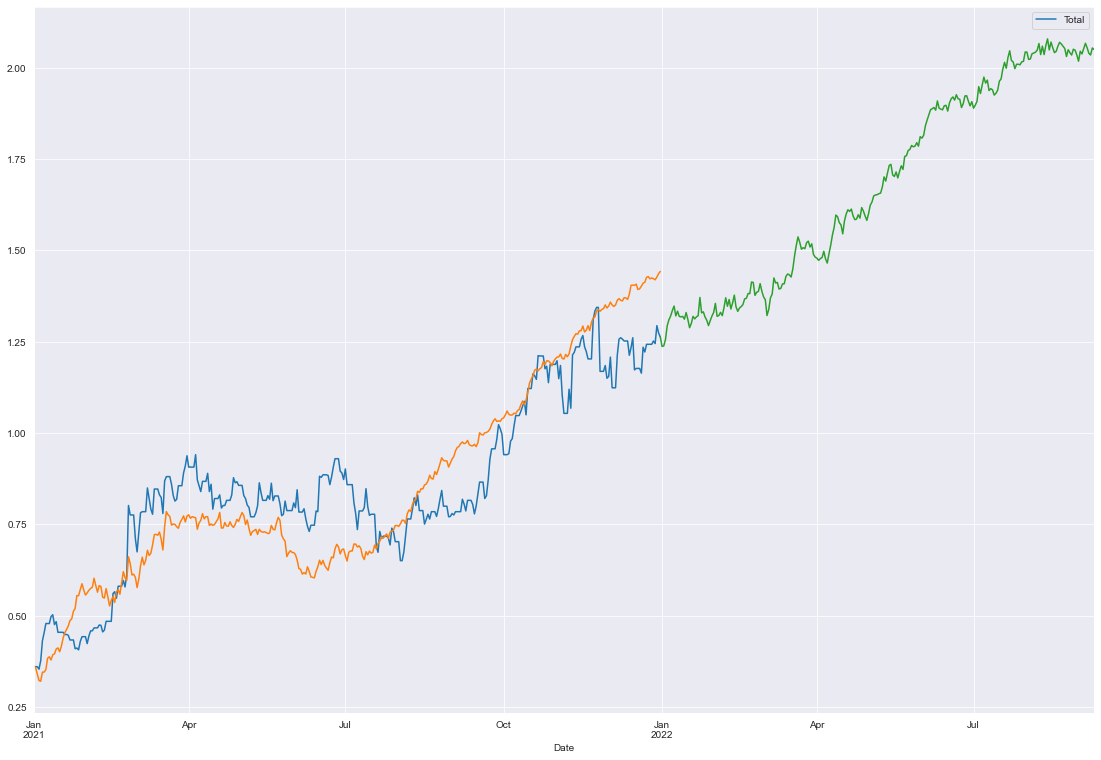

In [57]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [58]:
## Calculate annualized returns for forecasted

In [59]:
forecast

2021-12-31    1.263143
2022-01-01    1.237160
2022-01-02    1.238607
2022-01-03    1.255936
2022-01-04    1.293528
                ...   
2022-09-05    2.054294
2022-09-06    2.039348
2022-09-07    2.034550
2022-09-08    2.053812
2022-09-09    2.049633
Freq: D, Length: 253, dtype: float64

In [60]:
forecast_df = pd.DataFrame(forecast)

In [61]:
forecast_df

,0
2021-12-31,1.263143
2022-01-01,1.237160
2022-01-02,1.238607
2022-01-03,1.255936
2022-01-04,1.293528
...,...
2022-09-05,2.054294
2022-09-06,2.039348
2022-09-07,2.034550
2022-09-08,2.053812


In [62]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [63]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.020570
2022-01-02,-0.019424
2022-01-03,-0.005706
2022-01-04,0.024056
...,...
2022-09-05,0.626336
2022-09-06,0.614504
2022-09-07,0.610705
2022-09-08,0.625955


In [64]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2022-09-09  62.264569
